In [1]:
%run base.ipynb
%load_ext autoreload
%autoreload 2

import gym
import matplotlib.pyplot as plt

from abides_gym_market_making_environment_v2 import *
from policies_v1 import SigPolicy
from train_v2 import train
from test_v1_v2 import test
import utils

## Register the environment

In [2]:
# register market making env for gym use 
from gym.envs.registration import register

register(
    id="market-making-v2",
    entry_point=SubGymMarketsMarketMakingEnv_v2,
)

def generate_env(seed=None):
    """
    generates specific environment with the parameters defined and set the seed
    """
    env = gym.make(
            "market-making-v2",
            background_config="rmsc04",
            mkt_close="10:45:00",
            timestep_duration="10s",
            order_fixed_size=10,
            first_interval="00:10:00", #00:13:00
            observe_first_interval=False,
            max_inventory=100,
            mkt_order_alpha=0.2,
            terminal_inventory_reward=2, # reward
            inventory_reward_dampener=1., # 0.6,
            damp_mode="asymmetric",
            debug_mode=False
        )
    if seed is not None:
        env.seed(seed)
    
    return env

# create the environment
env = generate_env(2) #3,5

## Train a signature policy

In [3]:
episodes = 250
lr = 0.0001
window_length = None
eps = 1.0
eps_decay = utils.linear_decay(epochs=20_000, start=eps, end=0.02)

sigpolicy = SigPolicy(env, 5)
sigpolicy.initialize_parameters(factor=1, zero_bias=True)

results = train(env, 
                sigpolicy, 
                episodes,
                discount=1.0,
                learning_rate=lr, 
                exploration="greedy",
                epsilon=eps,
                epsilon_decay=eps_decay,
                window_length=window_length, 
                printing=False)

  0%|          | 0/250 [00:00<?, ?it/s]
 Episode 0 | step 100 | reward -0.8925000000000001 | loss 0.10791983489481227
Q values: tensor([0.0749, 0.0991, 0.0296, 0.1146], grad_fn=<SelectBackward>)

 Episode 0 | step 200 | reward -2.3799999999999986 | loss 0.21152495843173114
Q values: tensor([0.0968, 0.0948, 0.0101, 0.0803], grad_fn=<SelectBackward>)

 Episode 0 | step 300 | reward -3.4785499999999985 | loss 0.32653977415229285
Q values: tensor([ 0.1080,  0.0935, -0.0112,  0.0602], grad_fn=<SelectBackward>)

 Episode 0 | step 391 | reward -1.9724499999999987 | loss 1.8576447422441396
Q values: tensor([ 0.0508,  0.0777, -0.1098,  0.0274], grad_fn=<SelectBackward>)
  0%|          | 1/250 [00:24<1:43:29, 24.94s/it]
 Episode 1 | step 400 | reward -0.003 | loss 0.0015448961612491985
Q values: tensor([0.0082, 0.0174, 0.0397, 0.0273], grad_fn=<SelectBackward>)

 Episode 1 | step 500 | reward -0.43405000000000005 | loss 0.18562894590655982
Q values: tensor([-0.0149, -0.1199, -0.1430,  0.0260], g

#### Plot training results

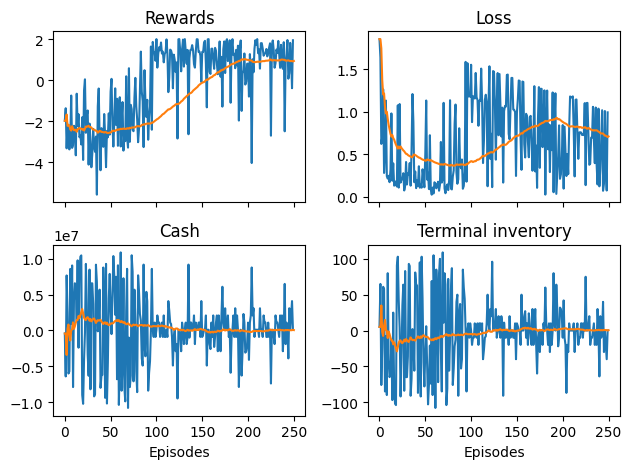

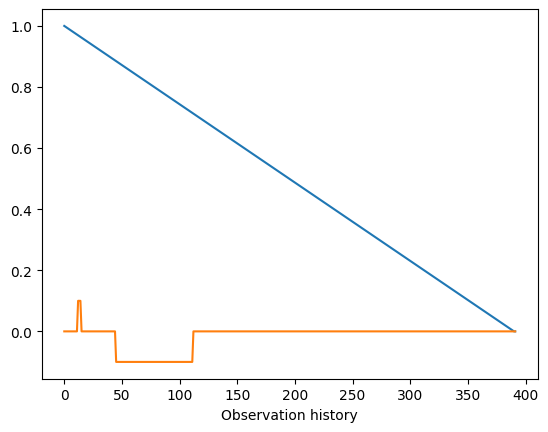

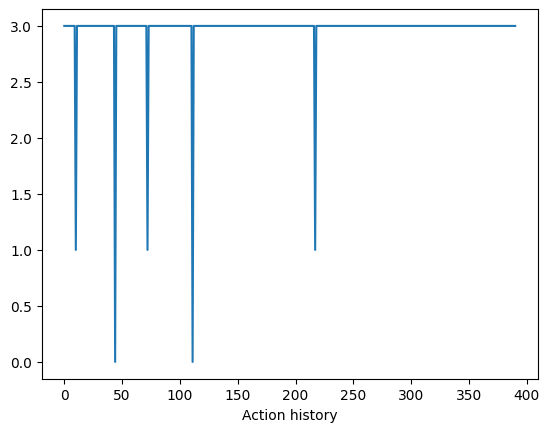

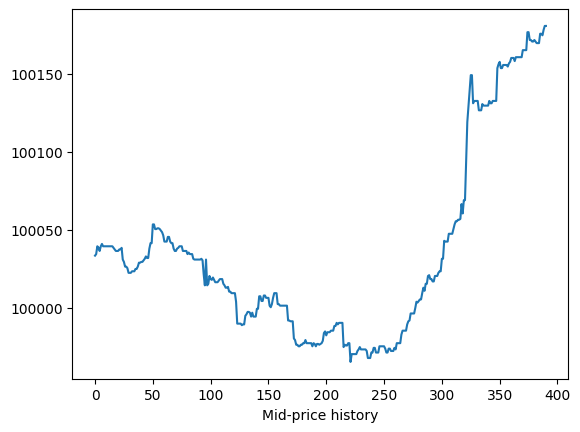

In [4]:

utils.plot_results([
    results["rewards"],
    results["losses"],
    results["cash"],
    results["terminal_inventory"],
])

id = -1

observation_history = list(results["observations"][id])
plt.plot(observation_history)
plt.xlabel("Observation history")
plt.show()

plt.plot(results["actions"][id])
plt.xlabel("Action history")
plt.show()

plt.plot(results["mid_prices"][id])
plt.xlabel("Mid-price history")
plt.show()


#### Save training results

In [5]:
# results_reduced_100_runs_0804_1  # without inventory reward
# results_reduced_50_runs_0804_2  # with inventory reward
# results_reduced_50_runs_0804_3 # with inventory reward and correct epsilon decay
# results_v2_200_runs_0808_1_convergence # inventory only model, with some convergence
# results_v2_250_runs_0809_1 # inventory only model, with convergence
# results_v2_250_runs_0809_2 # inventory only model, with convergence
# results_v2_250_runs_0810_1 # inventory only model, with convergence
# results_v2_250_runs_0811_1 # inventory only model, with no convergence
# results_v2_250_runs_0811_2 # inventory only model, with convergence
# results_v2_250_runs_0814_1 # inventory only model, with no convergence
# results_v2_250_runs_0814_2 # inventory only model, with no convergence
# results_v2_250_runs_0814_3 # inventory only model, with no convergence
# results_v2_250_runs_0814_3 # inventory only model, with no convergence
# results_v2_250_runs_0817_1 # inventory only model, with convergence
# results_v2_250_runs_0920_1 # inventory only model, with no convergence
# results_v2_250_runs_0920_2 # inventory only model, with convergence

import pickle

# write results 
with open('../results/results_NEW.pkl', 'wb') as f:  # open a text file
    pickle.dump(results, f) # serialize the list
f.close()

## Test a policy

#### Load training results

In [1]:
import pickle

# load results
with open('../results/results_v2_250_runs_0920_2.pkl', 'rb') as f:
    results = pickle.load(f)
f.close()

# load the parameters from saved checkpoint (every 10 episodes)
checkpoint = -1
sigpolicy = SigPolicy(env, 5)
sigpolicy.load_state_dict(results["intermediate"][checkpoint])

NameError: name 'SigPolicy' is not defined

#### Run tests

In [7]:
runs = 10
env = generate_env()
sigpolicy.eval()
test_results = test(env, sigpolicy, runs, epsilon=0)
sigpolicy.train()

  0%|          | 0/10 [00:00<?, ?it/s]
 Episode 0 | step 100 | reward 0.0 | inventory 0.0
Q values: tensor([[0.1552, 0.1646, 0.1603, 0.1796]], grad_fn=<AddmmBackward>)

 Episode 0 | step 200 | reward 0.0 | inventory 0.0
Q values: tensor([[0.2168, 0.2273, 0.2187, 0.2591]], grad_fn=<AddmmBackward>)

 Episode 0 | step 300 | reward 0.0 | inventory 0.0
Q values: tensor([[0.2941, 0.3111, 0.3014, 0.3713]], grad_fn=<AddmmBackward>)

 Episode 0 | step 391 | reward 2.0 | inventory 0.0
Q values: tensor([[0.3841, 0.4102, 0.4015, 0.5103]], grad_fn=<AddmmBackward>)
 10%|█         | 1/10 [00:13<02:04, 13.85s/it]
 Episode 1 | step 400 | reward 0.0 | inventory 0.0
Q values: tensor([[0.1078, 0.1216, 0.1251, 0.1288]], grad_fn=<AddmmBackward>)

 Episode 1 | step 500 | reward 0.0 | inventory 0.0
Q values: tensor([[0.1603, 0.1695, 0.1646, 0.1856]], grad_fn=<AddmmBackward>)

 Episode 1 | step 600 | reward 0.0 | inventory 0.0
Q values: tensor([[0.2230, 0.2339, 0.2251, 0.2677]], grad_fn=<AddmmBackward>)

 Epis

SigPolicy(
  (linear): Linear(in_features=62, out_features=4, bias=True)
)

#### Plot testing results

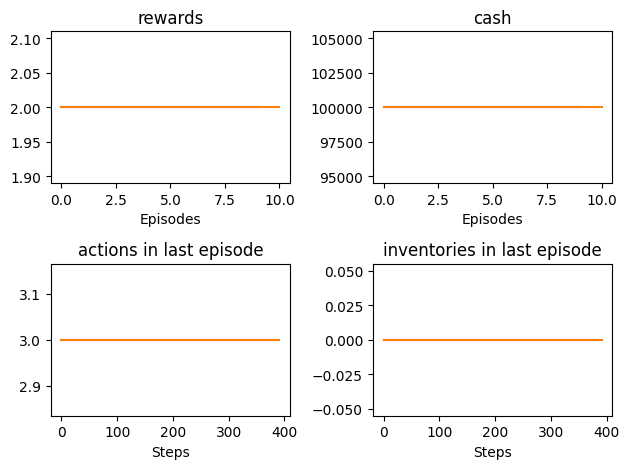

In [12]:
episode_id = -1
avg_window = 100
names = ["rewards", "cash", "actions", "inventories"]
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False)
for ax, id in zip(axes.flat, range(4)):
    ax.set_title(names[id] if id < 2 else names[id] + (
                     " in episode " + str(episode_id) if episode_id != -1 else " in last episode")
    )
    ax.plot(test_results[names[id]] if id < 2 else test_results[names[id]][episode_id])
    ax.plot(utils.moving_average(
            test_results[names[id]] if id < 2 else test_results[names[id]][episode_id], avg_window
        ))
    ax.set_xlabel("Episodes" if id < 2 else "Steps")
fig.tight_layout()
plt.show()

#### Check first Q-value convergence

**Note**: We need to compare this with the average episode reward once all runs are performed. Also longer runs might be needed since I expect the average episode reward to be above the Q values reached with 250 episodes 

In [ ]:
import torch

policy = SigPolicy(env, 5)
first_history = list(results["observations"][0])[0:30]
first_history = torch.tensor(
    first_history, requires_grad=False, dtype=torch.float
).unsqueeze(0)
first_Q_values = []

for state_dict in results["intermediate"]: #range(len(results["intermediate"])):
    policy.eval()
    policy.load_state_dict(state_dict)    
    sig = policy.update_signature(first_history)  
    first_Q_values.append(policy(sig).detach())       

first_Q_values = torch.cat(first_Q_values, dim=0)
plt.plot(first_Q_values[:,3])
